Цель исследования - понять, какой тариф приносит больше денег. Нужно проверить две гипотезы: что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

Ход исследования:
    перед проверкой гипотез нужно провести обзор данных, предобработка и исправление критичных ошибок, если такие будут обнаружены. Понадобится также провести некоторые расчёты, например, расчёт выручки, и проанализировать поведение клиентов на основе выборки. Затем нужно будет описать распределение, и после этого проверить гипотезы. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Предобработка данных

### Датафрейм internet

In [3]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [4]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
internet.duplicated(subset=None, keep='first').sum()

0

In [6]:
internet.dtypes

id               object
mb_used         float64
session_date     object
user_id           int64
dtype: object

In [7]:
internet['month'] = internet['session_date'].astype('datetime64[M]')

In [8]:
internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

    
internet.head()    

,user_id,month,mb_used
0,1000,2018-05-01,2253.49
1,1000,2018-06-01,23233.77
2,1000,2018-07-01,14003.64
3,1000,2018-08-01,14055.93
4,1000,2018-09-01,14568.91


In [9]:
#округление мб до гб
internet['gb_used'] = internet['mb_used']/1024

internet['gb_used'] = np.ceil(internet['gb_used'])

internet.drop(columns=['mb_used'], axis=1, inplace = True) 
internet.head()

,user_id,month,gb_used
0,1000,2018-05-01,3.0
1,1000,2018-06-01,23.0
2,1000,2018-07-01,14.0
3,1000,2018-08-01,14.0
4,1000,2018-09-01,15.0


### Датафрейм calls

In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [11]:
calls.duplicated(subset=None, keep='first').sum()

0

In [12]:
calls['month'] = calls['call_date'].astype('datetime64[M]')

#округление продолжительности разговора
calls['duration'] = np.ceil(calls['duration'])

calls.head()    

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,2018-07-01
1,1000_1,2018-08-17,0.0,1000,2018-08-01
2,1000_2,2018-06-11,3.0,1000,2018-06-01
3,1000_3,2018-09-21,14.0,1000,2018-09-01
4,1000_4,2018-12-15,6.0,1000,2018-12-01


In [13]:
calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()
calls.head()

,user_id,month,duration
0,1000,2018-05-01,159.0
1,1000,2018-06-01,172.0
2,1000,2018-07-01,340.0
3,1000,2018-08-01,408.0
4,1000,2018-09-01,466.0


### Датафрейм messages

In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [15]:
messages.duplicated(subset=None, keep='first').sum()

0

In [16]:
messages['month'] = messages['message_date'].astype('datetime64[M]')
messages = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages.head()

,user_id,month,id
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


### Датафрейм users

In [17]:
users.info()
users.duplicated(subset=None, keep='first').sum()
users['tariff'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


array(['ultra', 'smart'], dtype=object)

In [18]:
#выделим в отдельную таблицу информацию о тарифе каждого клиента
tarif = users[['user_id', 'tariff']]
tarif.head()

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


### Датафрейм tariffs

In [19]:
tariffs.duplicated(subset=None, keep='first').sum()
tariffs = tariffs.rename(columns={"tariff_name": "tariff"})

tariffs.info()
tariffs['gb_included'] = tariffs['mb_per_month_included']/1024
tariffs = tariffs.drop(columns='mb_per_month_included')
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_included
0,50,500,550,200,3,3,smart,15.0
1,1000,3000,1950,150,1,1,ultra,30.0


Вывод: пропусков в исходных данных не обнаружилось, но т.к. в таблицах с данными по интернет-трафику, звонкам и сообщениям количество строк разное, при их соединении появятся нулевые значения.

### Объединение таблиц

In [20]:
df = internet.merge(calls, on=['user_id', 'month'], how='outer')
df = df.merge(messages, on = ['user_id', 'month'], how='outer')
df = df.merge(tarif, on='user_id', how='outer')

display(df.head())
df = df.rename(columns={"duration": "minutes", "id": "messages"})

,user_id,month,gb_used,duration,id,tariff
0,1000,2018-05-01,3.0,159.0,22.0,ultra
1,1000,2018-06-01,23.0,172.0,60.0,ultra
2,1000,2018-07-01,14.0,340.0,75.0,ultra
3,1000,2018-08-01,14.0,408.0,81.0,ultra
4,1000,2018-09-01,15.0,466.0,57.0,ultra


In [21]:
users['user_id'].nunique()

500

In [22]:
df['user_id'].nunique()

500

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   3216 non-null   int64         
 1   month     3214 non-null   datetime64[ns]
 2   gb_used   3203 non-null   float64       
 3   minutes   3174 non-null   float64       
 4   messages  2717 non-null   float64       
 5   tariff    3216 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 175.9+ KB


Подтвердился вывод из предыдущего этапа: появились нулевые значения, т.к. не все клиенты пользовались одновременно интеренетом, звонками и сообщениями. 

In [24]:
df['month'].isnull()
df.tail(2)
#можно сразу отбросить этих двух пользователей, т.к. о них нет вообще никакой информации
df.drop(index=[3214, 3215], inplace=True)

In [25]:
#в остальных случаях пропуски можно заменить на ноль
df.fillna(0, inplace=True)

### Расчёт выручки

Считаем помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [26]:
#разделим пользователей по тарифу
df1 = df.query('tariff=="ultra"')
sub_fee = 1950               
df1 = df1.assign(income=sub_fee)

df1 = df1.merge(tariffs, on='tariff')
df1.head()

,user_id,month,gb_used,minutes,messages,tariff,income,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included
0,1000,2018-05-01,3.0,159.0,22.0,ultra,1950,1000,3000,1950,150,1,1,30.0
1,1000,2018-06-01,23.0,172.0,60.0,ultra,1950,1000,3000,1950,150,1,1,30.0
2,1000,2018-07-01,14.0,340.0,75.0,ultra,1950,1000,3000,1950,150,1,1,30.0
3,1000,2018-08-01,14.0,408.0,81.0,ultra,1950,1000,3000,1950,150,1,1,30.0
4,1000,2018-09-01,15.0,466.0,57.0,ultra,1950,1000,3000,1950,150,1,1,30.0


In [27]:
df1.info()
df1['income'] = df1['income'].astype('float')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 984
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            985 non-null    int64         
 1   month              985 non-null    datetime64[ns]
 2   gb_used            985 non-null    float64       
 3   minutes            985 non-null    float64       
 4   messages           985 non-null    float64       
 5   tariff             985 non-null    object        
 6   income             985 non-null    int64         
 7   messages_included  985 non-null    int64         
 8   minutes_included   985 non-null    int64         
 9   rub_monthly_fee    985 non-null    int64         
 10  rub_per_gb         985 non-null    int64         
 11  rub_per_message    985 non-null    int64         
 12  rub_per_minute     985 non-null    int64         
 13  gb_included        985 non-null    float64       
dtypes: datetim

In [28]:
free_minutes = 500
free_gb = 15
free_sms = 50
extra_min = 3
extra_gb = 200
extra_sms = 3           



for a in df1.index:
    min = df1.at[a, 'minutes']
    df1.at[a, 'income'] = df1.at[a, 'income'] if min <= free_minutes else df1.at[a, 'income'] + (min-free_minutes)*extra_min      

for b in df1.index:
    gb = df1.at[b, 'gb_used']
    df1.at[b, 'income'] = df1.at[b, 'income'] if gb <= free_gb else df1.at[b, 'income'] + (gb-free_gb)*extra_gb
    
for c in df1.index:
    sms = df1.at[c, 'messages']
    df1.at[c, 'income'] = df1.at[c, 'income'] if sms <= free_sms else df1.at[c, 'income'] + (sms-free_sms)*extra_sms
    
df1.head()

,user_id,month,gb_used,minutes,messages,tariff,income,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included
0,1000,2018-05-01,3.0,159.0,22.0,ultra,1950.0,1000,3000,1950,150,1,1,30.0
1,1000,2018-06-01,23.0,172.0,60.0,ultra,3580.0,1000,3000,1950,150,1,1,30.0
2,1000,2018-07-01,14.0,340.0,75.0,ultra,2025.0,1000,3000,1950,150,1,1,30.0
3,1000,2018-08-01,14.0,408.0,81.0,ultra,2043.0,1000,3000,1950,150,1,1,30.0
4,1000,2018-09-01,15.0,466.0,57.0,ultra,1971.0,1000,3000,1950,150,1,1,30.0


In [29]:
df2 = df.query('tariff=="smart"')
sub_fee = 550               
df2 = df2.assign(income=sub_fee)
df2.head()

,user_id,month,gb_used,minutes,messages,tariff,income
8,1001,2018-11-01,18.0,430.0,0.0,smart,550
9,1001,2018-12-01,14.0,414.0,0.0,smart,550
10,1002,2018-06-01,11.0,117.0,4.0,smart,550
11,1002,2018-07-01,18.0,214.0,11.0,smart,550
12,1002,2018-08-01,20.0,289.0,13.0,smart,550


In [30]:
df2.info()
df2['income'] = df2['income'].astype('float')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3205
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   2229 non-null   int64         
 1   month     2229 non-null   datetime64[ns]
 2   gb_used   2229 non-null   float64       
 3   minutes   2229 non-null   float64       
 4   messages  2229 non-null   float64       
 5   tariff    2229 non-null   object        
 6   income    2229 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 139.3+ KB


In [31]:
free_minutes = 500
free_gb = 15
free_sms = 50
extra_min = 3
extra_gb = 200
extra_sms = 3               

        
for a in df2.index:
    min = df2.at[a, 'minutes']
    df2.at[a, 'income'] = df2.at[a, 'income'] if min <= free_minutes else df2.at[a, 'income'] + (min-free_minutes)*extra_min      

for b in df2.index:
    gb = df2.at[b, 'gb_used']
    df2.at[b, 'income'] = df2.at[b, 'income'] if gb <= free_gb else df2.at[b, 'income'] + (gb-free_gb)*extra_gb
    
for c in df2.index:
    sms = df2.at[c, 'messages']
    df2.at[c, 'income'] = df2.at[c, 'income'] if sms <= free_sms else df2.at[c, 'income'] + (sms-free_sms)*extra_sms
    
df2.head()

,user_id,month,gb_used,minutes,messages,tariff,income
8,1001,2018-11-01,18.0,430.0,0.0,smart,1150.0
9,1001,2018-12-01,14.0,414.0,0.0,smart,550.0
10,1002,2018-06-01,11.0,117.0,4.0,smart,550.0
11,1002,2018-07-01,18.0,214.0,11.0,smart,1150.0
12,1002,2018-08-01,20.0,289.0,13.0,smart,1550.0


Вывод: на первый взгляд кажется, что средние выручки пользователей разных тарифов различаются (у пользователей тарифа "Ультра" выручка больше). 

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.



Среднее количество минут разговора: 526.6233502538071
Дисперсия: 100873.63339730098
Стандартное отклонение: 317.44483554974113


518.0

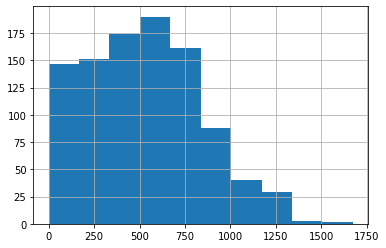

In [34]:
ultra = df1
smart = df2

ultra_minutes_mu = ultra['minutes'].mean()
ultra_minutes_var = np.var(ultra['minutes'], ddof=1)
ultra_minutes_std = np.std(ultra['minutes'])
print('Среднее количество минут разговора:', ultra_minutes_mu)
print('Дисперсия:', ultra_minutes_var)
print('Стандартное отклонение:', ultra_minutes_std)

# построим гистограмму для непрерывной переменной
ultra['minutes'].hist()
ultra['minutes'].median()
#данные скошены вправо

Среднее количество минут разговора: 417.9349484073576
Дисперсия: 36219.31578434428
Стандартное отклонение: 190.27103471651876


422.0

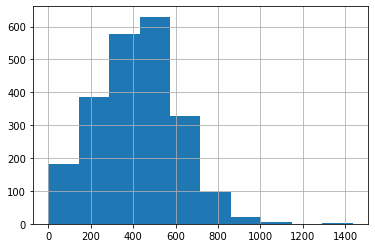

In [35]:
smart_minutes_mu = smart['minutes'].mean()
smart_minutes_var = np.var(smart['minutes'], ddof=1)
smart_minutes_std = np.std(smart['minutes'])
print('Среднее количество минут разговора:', smart_minutes_mu)
print('Дисперсия:', smart_minutes_var)
print('Стандартное отклонение:', smart_minutes_std)

smart['minutes'].hist()
smart['minutes'].median()
#данные скошены влево

Средний объём трафика: 19.494416243654822
Дисперсия: 97.09168626965457
Стандартное отклонение: 9.848508314957494


19.0

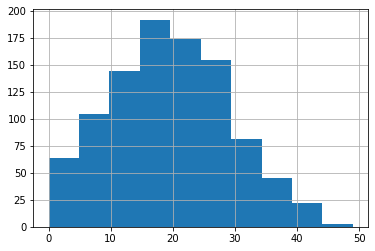

In [36]:
ultra_gb_mu = ultra['gb_used'].mean()
ultra_gb_var = np.var(ultra['gb_used'], ddof=1)
ultra_gb_std = np.std(ultra['gb_used'])
print('Средний объём трафика:', ultra_gb_mu)
print('Дисперсия:', ultra_gb_var)
print('Стандартное отклонение:', ultra_gb_std)

ultra['gb_used'].hist()
ultra['gb_used'].median()
#распределение близко к нормальному

Средний объём трафика: 16.328847016599372
Дисперсия: 33.02870517811161
Стандартное отклонение: 5.745771267187499


19.0

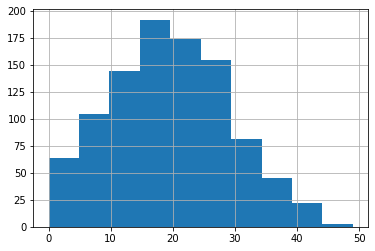

In [37]:
smart_gb_mu = smart['gb_used'].mean()
smart_gb_var = np.var(smart['gb_used'], ddof=1)
smart_gb_std = np.std(smart['gb_used'])
print('Средний объём трафика:', smart_gb_mu)
print('Дисперсия:', smart_gb_var)
print('Стандартное отклонение:', smart_gb_std)

ultra['gb_used'].hist()
ultra['gb_used'].median()
#данные скошены влево 

Среднее количество сообщений: 49.36345177664975
Дисперсия: 2285.266142544674
Стандартное отклонение: 47.78018496610161


38.0

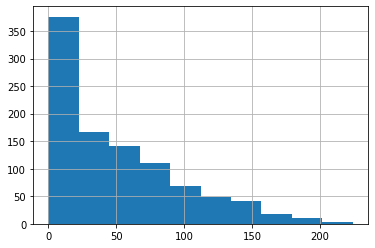

In [38]:
ultra_sms_mu = ultra['messages'].mean()
ultra_sms_var = np.var(ultra['messages'], ddof=1)
ultra_sms_std = np.std(ultra['messages'])
print('Среднее количество сообщений:', ultra_sms_mu)
print('Дисперсия:', ultra_sms_var)
print('Стандартное отклонение:', ultra_sms_std)

ultra['messages'].hist()
ultra['messages'].median()
#данные скошены вправо

Среднее количество сообщений: 33.384028712427096
Дисперсия: 796.8129584480083
Стандартное отклонение: 28.221542886898938


28.0

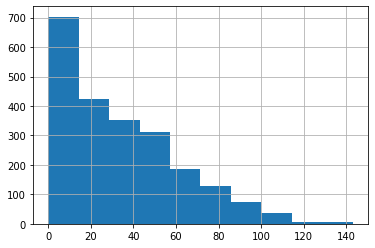

In [39]:
smart_sms_mu = smart['messages'].mean()
smart_sms_var = np.var(smart['messages'], ddof=1)
smart_sms_std = np.std(smart['messages'])
print('Среднее количество сообщений:', smart_sms_mu)
print('Дисперсия:', smart_sms_var)
print('Стандартное отклонение:', smart_sms_std)

smart['messages'].hist()
smart['messages'].median()
#данные скошены вправо

In [40]:
df.groupby('tariff')[['minutes','gb_used', 'messages']].agg(['mean','var','std']).round(0)

minutes                  gb_used             messages              
          mean       var    std    mean   var   std     mean     var   std
tariff                                                                    
smart    418.0   36219.0  190.0    16.0  33.0   6.0     33.0   797.0  28.0
ultra    527.0  100874.0  318.0    19.0  97.0  10.0     49.0  2285.0  48.0

## Проверка гипотез

Проверим две гипотезы:
    средние выручки пользователей тарифов «Ультра» и «Смарт» различаются;
    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [41]:
ultra_income = ultra.pivot_table(index='user_id', values='income', aggfunc='sum').reset_index()

smart_income = smart.pivot_table(index='user_id', values='income', aggfunc='sum').reset_index()

In [42]:
alpha = 0.05

<AxesSubplot:xlabel='income', ylabel='Density'>

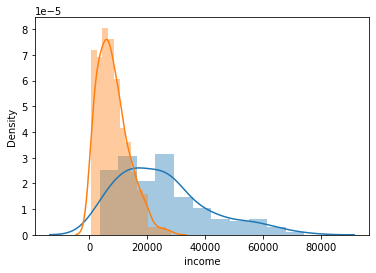

In [43]:
#проверка нормальности распределения
sns.distplot(ultra_income['income'])
sns.distplot(smart_income['income'])

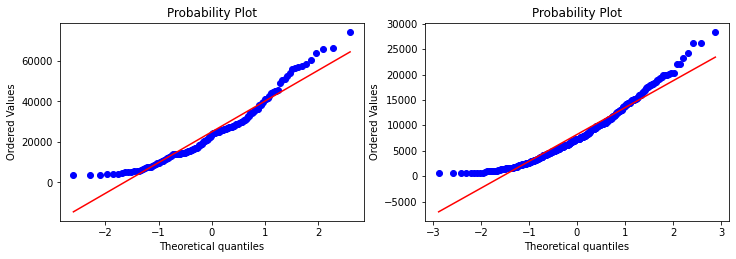

In [44]:
#проверка с помощью qq-plot 
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(ultra_income['income'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(smart_income['income'], dist="norm", plot=plt)
plt.show()

Введём основную и альтернативную гипотезы. H0: средние выручки пользователей тарифов «Ультра» и «Смарт» одинаковы, H1: средние выручки пользователей тарифов «Ультра» и «Смарт» различаются. 
Посчитаем p-value, используя ttest из библиотеки scipy для сравнения средних двух выборок.

Если p-value будет меньше выбранного уровня значимости  α=0.05 , то нулевую гипотезу о равенстве средних отвергнем. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

Применим непараметрический тест, т.к. совокупности распределены не нормально

In [45]:
results = st.mannwhitneyu(smart_income['income'], ultra_income['income'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  8.366185670589655e-38
Отвергаем нулевую гипотезу


Применим ttest к выручкам пользователей двух тарифов (выборки независимые), чтобы проверить, как его результат будет отличаться от результата непараметрического теста.

In [46]:
results = st.ttest_ind(smart_income['income'], ultra_income['income'], equal_var=False)
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.0669117888763587e-26
Отвергаем нулевую гипотезу


Проверим вторую гипотезу. H0: средние выручки пользователей из Москвы и из других регионов одинаковы, H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [47]:
user_city = users[['user_id', 'city']]
data = pd.concat([ultra, smart])
data = data.merge(user_city, on='user_id')
data.head()

,user_id,month,gb_used,minutes,messages,tariff,income,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included,city
0,1000,2018-05-01,3.0,159.0,22.0,ultra,1950.0,1000.0,3000.0,1950.0,150.0,1.0,1.0,30.0,Краснодар
1,1000,2018-06-01,23.0,172.0,60.0,ultra,3580.0,1000.0,3000.0,1950.0,150.0,1.0,1.0,30.0,Краснодар
2,1000,2018-07-01,14.0,340.0,75.0,ultra,2025.0,1000.0,3000.0,1950.0,150.0,1.0,1.0,30.0,Краснодар
3,1000,2018-08-01,14.0,408.0,81.0,ultra,2043.0,1000.0,3000.0,1950.0,150.0,1.0,1.0,30.0,Краснодар
4,1000,2018-09-01,15.0,466.0,57.0,ultra,1971.0,1000.0,3000.0,1950.0,150.0,1.0,1.0,30.0,Краснодар


In [48]:
msc = data.query('city=="Москва"')
reg = data.query('city!="Москва"')
msc_ultra_income = msc.pivot_table(index='user_id', values='income', aggfunc='sum').reset_index()
reg_ultra_income = reg.pivot_table(index='user_id', values='income', aggfunc='sum').reset_index()

<AxesSubplot:xlabel='income', ylabel='Density'>

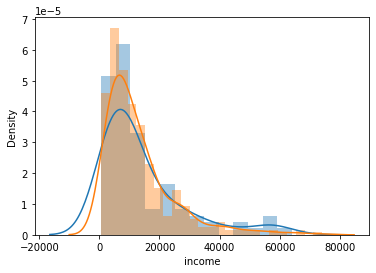

In [49]:
#проверка нормальности распределения
sns.distplot(msc_ultra_income['income'])
sns.distplot(reg_ultra_income['income'])

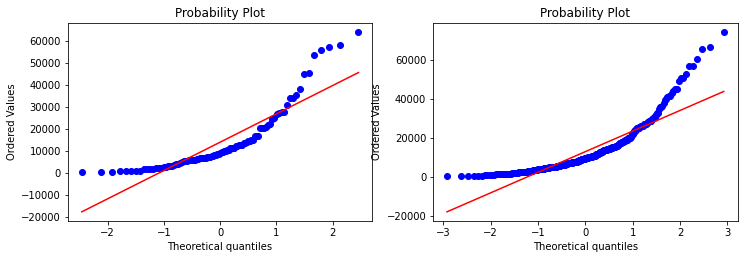

In [50]:
#проверка с помощью qq-plot 
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(msc_ultra_income['income'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(reg_ultra_income['income'], dist="norm", plot=plt)
plt.show()

Проведём непараметрический тест:

In [51]:
results = st.mannwhitneyu(msc_ultra_income['income'], reg_ultra_income['income'], alternative='two-sided')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.8091759792112039
Не получилось отвергнуть нулевую гипотезу


##  Общий вывод
При заданном уровне значимости на основе проведённых тестов есть основания отвергнуть две гипотезы: что средние выручки пользователей тарифов "Ультра" и "Смарт" одинаковы; что средние выручки пользователей из Москвы и из других регионов одинаковы. 